In [62]:
using DifferentialEquations
using SpecialFunctions
using Plots
using XLSX

In [73]:
# EXTRACTING OPEN MAGNETIC FLUX AND SUNSPOT NUMBER RECORDS FROM XLSX FILE

# Initialize vectors
years = Vector{Float64}()
open_magn_flux = Vector{Float64}()
open_magn_flux_err = Vector{Float64}()
ssa_open_magn_flux = Vector{Float64}()
sunsopts_num = Vector{Float64}()
sunspots_err = Vector{Float64}()
ssa_sunspots = Vector{Float64}()

# Read from xlsx file the data
XLSX.openxlsx("SN Usoskin Brehm.xlsx") do file
  sheet = file["Data"]

  for row in XLSX.eachrow(sheet)
    year = row[2]
    omf = row[3]
    omf_err = row[4]
    omf_ssa = row[5]
    sun_num = row[7]
    sun_err = row[8]
    sun_ssa = row[9]
    
    # Check if the rows values are numeric (and not empty nor strings)
    if isa(year, Number)
      push!(years, year)
      push!(open_magn_flux, omf)
      push!(open_magn_flux_err, omf_err)
      push!(ssa_open_magn_flux, omf_ssa)
      push!(sunsopts_num, sun_num)
      push!(sunspots_err, sun_err)
      push!(ssa_sunspots, sun_ssa)
    end
  end
end

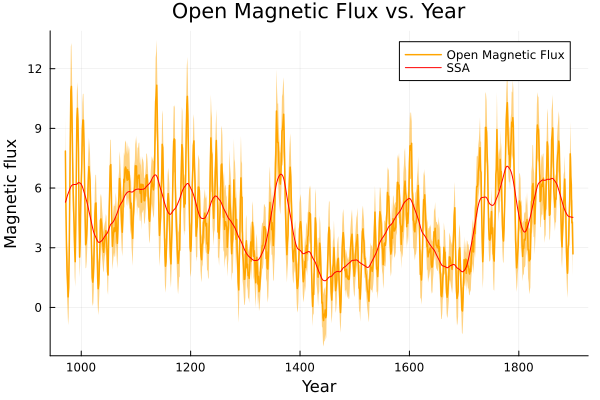

In [74]:
# PLOTTING OF THE OPEN MAGNETIC FLUX RECORDS FROM 971 TO 1899 (AD)

plot(years, open_magn_flux, ribbon = open_magn_flux_err, xlabel = "Year", ylabel = "Magnetic flux", 
    title = "Open Magnetic Flux vs. Year", label = "Open Magnetic Flux", linewidth = 1.5, color = "orange")
plot!(years, ssa_open_magn_flux, label = "SSA", linewidth = 1, color = "red")

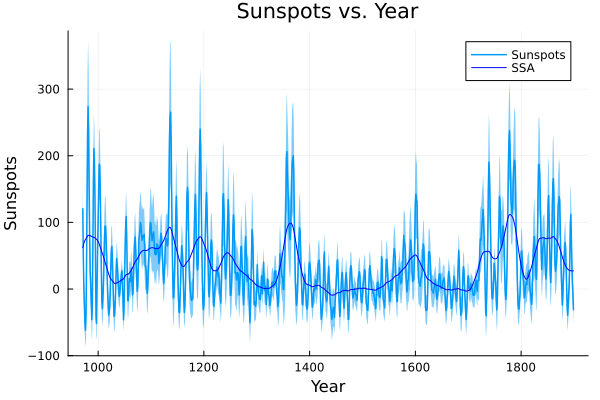

In [75]:
# PLOTTING OF THE SUNSPOT RECORDS FROM 971 TO 1899 (AD)

plot(years, sunsopts_num, ribbon = sunspots_err, xlabel = "Year", ylabel = "Sunspots", 
    title = "Sunspots vs. Year", label = "Sunspots", linewidth = 1.5)
plot!(years, ssa_sunspots, label = "SSA", linewidth = 1, color = "blue")

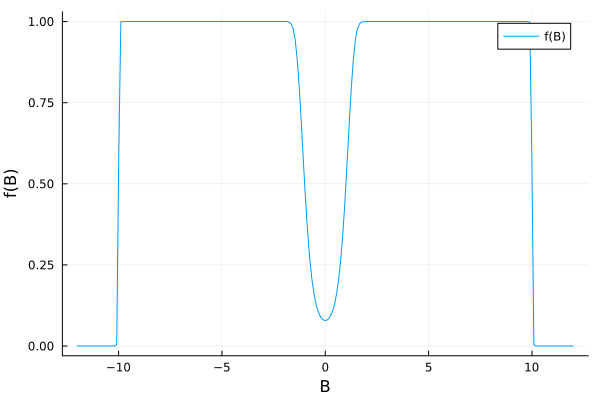

In [76]:
# BOX-SHAPED FUNCTION FOR THE MAGNETIC FIELD RANGE 

# Define limits
B_min = 1
B_max = 10

# Define the function
function f(B)
    return 1 / 4 * (1 .+ erf.(B .^ 2 .- B_min ^ 2)) .* (1 .- erf.(B .^ 2 .- B_max ^ 2))
end

# Plot (range [-12, 12])
B_values = range(-12, stop = 12, length = 240)
f_values = f(B_values)
plot(B_values, f_values, xlabel = "B", ylabel = "f(B)", label = "f(B)")

##############################################################

# DIMENSION OF THE MAGNETIC FIELD???

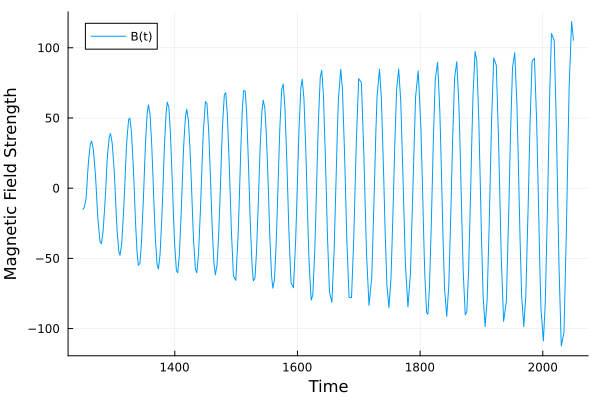

In [77]:
# DDE PROBLEM WITHOUT NOISE AND PERIODIC MODULATION

# Define parameters
N = 8.4
q = 0.82
tau = 5
p = [N, q, tau]

# Define initial conditions
B0 = [-15, 0, 0]
tspan = (1250, 2050.0)
h(p, t) = [0.0, 0.0, 0.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, q, tau = p

  B = u[1]
  dB = u[2]
  ddB = u[3]

  du[1] = ddB
  du[2] = -2 * dB
  du[3] = (- B - N * h(p, t - q)[1] * f(h(p, t - q)[1])) / (tau^2)
end

# Define and solve the DDE problem
prob = DDEProblem(MagneticField, B0, h, tspan, p)
sol = solve(prob, MethodOfSteps(Tsit5()))

# Plot 
plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", linewidth = 1)
#plot!(sol.t, sol[2, :], label="dB/dt", linewidth=1)
#plot!(sol.t, sol[3, :], label="d^2B/dt^2", linewidth=1)

######################################

# DIMENSIONS??? 
# WHY THE PERIOD DOESN'T MATCH?
# WHY IS NOT CONSTANT?
# WHY IT GOES OVER 100?

In [79]:
# Define parameters
N = 8.4
q = 0.82
tau = 5
p = [N, q, tau]

# Define initial conditions
B0 = [-15, 0, 0]
tspan = (1250, 2050.0)
h(p, t) = [0.0, 0.0, 0.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
    N, q, tau = p

    B = u[1]
    dB = u[2]
    ddB = u[3]

    du[1] = ddB
    du[2] = -2 * dB
    du[3] = (- B - N * h(p, t - q)[1] * f(h(p, t - q)[1])) / (tau^2)
end

# Define noise function
function noise(du, u, h, p, t)
    sigma, Bmax = p
    du[1] = sigma * Bmax
end

# Define and solve the SDDE problem
prob = SDDEProblem(MagneticField, noise, B0, h, tspan, p)
sol = solve(prob, EM())

# Plot 
plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", linewidth = 1)

LoadError: MethodError: no method matching default_algorithm(::SDDEProblem{Vector{Float64}, Tuple{Float64, Float64}, Tuple{}, Tuple{}, true, Vector{Float64}, Nothing, SDDEFunction{true, SciMLBase.FullSpecialize, typeof(MagneticField), typeof(noise), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, typeof(noise), typeof(h), Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, Nothing})

[0mClosest candidates are:
[0m  default_algorithm([91m::SciMLBase.AbstractDDEProblem{uType, tType, lType, isinplace}[39m; kwargs...) where {uType, tType, lType, isinplace}
[0m[90m   @[39m [33mDifferentialEquations[39m [90m~/.julia/packages/DifferentialEquations/Tu7HS/src/[39m[90m[4mdde_default_alg.jl:1[24m[39m
[0m  default_algorithm([91m::SciMLBase.AbstractBVProblem[39m; kwargs...)
[0m[90m   @[39m [33mDifferentialEquations[39m [90m~/.julia/packages/DifferentialEquations/Tu7HS/src/[39m[90m[4mbvp_default_alg.jl:1[24m[39m
[0m  default_algorithm([91m::SciMLBase.AbstractDiscreteProblem[39m; kwargs...)
[0m[90m   @[39m [33mDifferentialEquations[39m [90m~/.julia/packages/DifferentialEquations/Tu7HS/src/[39m[90m[4mdiscrete_default_alg.jl:1[24m[39m
[0m  ...


In [55]:
# DDE PROBLEM WITHOUT NOISE AND PERIODIC MODULATION

# Define parameters
N = 8.4
q = 0.82
tau = 5
p = [N, q, tau]

# Define initial conditions
B0 = [-15, 0, 0]
tspan = (1250, 2050.0)
h(p, t) = [0.0, 0.0, 0.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, q, tau = p

  B = u[1]
  dB = u[2]
  ddB = u[3]

  du[1] = ddB
  du[2] = -2 * dB
  du[3] = (- B - N * h(p, t - q)[1] * f(h(p, t - q)[1])) / (tau^2)
end

# Define noise function
function noise(du, u, h, p, t)
  sigma, Bmax = p
  du[1] = sigma * Bmax
end

# Define and solve the DDE problem
prob = SDDEProblem(MagneticField, noise, B0, h, tspan, p)
sol = solve(prob, RKMil())

# Plot 
plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", linewidth = 1)
#plot!(sol.t, sol[2, :], label="dB/dt", linewidth=1)
#plot!(sol.t, sol[3, :], label="d^2B/dt^2", linewidth=1)

######################################

# DIMENSIONS??? 
# WHY THE PERIOD DOESN'T MATCH?
# WHY IS NOT CONSTANT?
# WHY IT GOES OVER 100?

LoadError: MethodError: no method matching default_algorithm(::SDDEProblem{Vector{Float64}, Tuple{Float64, Float64}, Tuple{}, Tuple{}, true, Vector{Float64}, Nothing, SDDEFunction{true, SciMLBase.FullSpecialize, typeof(MagneticField), typeof(noise), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, typeof(noise), typeof(h), Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, Nothing})

[0mClosest candidates are:
[0m  default_algorithm([91m::SciMLBase.AbstractDDEProblem{uType, tType, lType, isinplace}[39m; kwargs...) where {uType, tType, lType, isinplace}
[0m[90m   @[39m [33mDifferentialEquations[39m [90m~/.julia/packages/DifferentialEquations/Tu7HS/src/[39m[90m[4mdde_default_alg.jl:1[24m[39m
[0m  default_algorithm([91m::SciMLBase.AbstractBVProblem[39m; kwargs...)
[0m[90m   @[39m [33mDifferentialEquations[39m [90m~/.julia/packages/DifferentialEquations/Tu7HS/src/[39m[90m[4mbvp_default_alg.jl:1[24m[39m
[0m  default_algorithm([91m::SciMLBase.AbstractDiscreteProblem[39m; kwargs...)
[0m[90m   @[39m [33mDifferentialEquations[39m [90m~/.julia/packages/DifferentialEquations/Tu7HS/src/[39m[90m[4mdiscrete_default_alg.jl:1[24m[39m
[0m  ...
